In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
import pandas as pd

In [2]:
Theta = 20
M1 = [1.5, 2.0, 2.5] 
gamma = 1.4

In [3]:
def y(Theta, M1, gamma, beta):
    return (
        np.tan(Theta) - 2 * np.tan(beta)**(-1) * (
            M1**2 * np.sin(beta)**2 - 1
        ) / (
            M1**2 * (gamma + np.cos(2 * beta)) + 2
        )
    )

In [4]:
def Theta(beta, M1, gamma):
    return np.rad2deg(
            np.arctan(
            2 * np.tan(np.deg2rad(beta))**(-1) * (
                M1**2 * np.sin(np.deg2rad(beta))**2 - 1
            ) / (
                M1**2 * (gamma + np.cos(2 * np.deg2rad(beta))) + 2
            )
        )
    )

Theta(53, 2, 1.4)

19.78994896194563

In [5]:
def find_beta_for_theta(theta_target, M1, gamma, initial_guess=50):
    def f(beta):
        return Theta(beta, M1, gamma) - theta_target
    return fsolve(f, initial_guess)[0]

<>:13: SyntaxWarning: invalid escape sequence '\T'
<>:13: SyntaxWarning: invalid escape sequence '\T'
/var/folders/v_/5q1gkdc53z34pdsfnpkx2t340000gn/T/ipykernel_10159/3805428997.py:13: SyntaxWarning: invalid escape sequence '\T'
  plt.xlabel('$\Theta$ [°]')


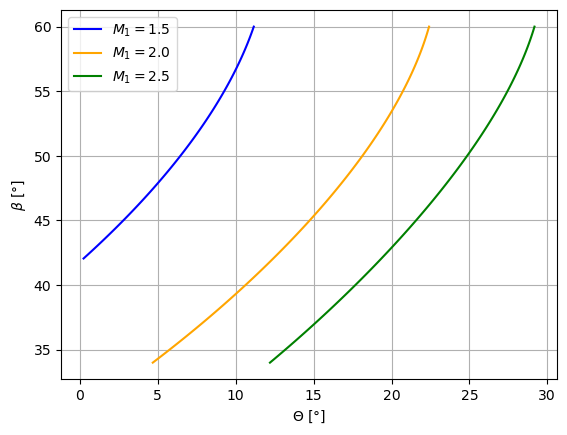

In [ ]:
beta_angle = np.linspace(34,60,101)
Theta_M = [Theta(beta_angle, M1_, gamma) for M1_ in M1]
colors = ['blue', 'orange', 'green']

plt.figure()
for i, Theta_ in enumerate(Theta_M):
    # Filter out negative Theta values
    positive_mask = Theta_ > 0
    if np.any(positive_mask):  # Only plot if there are positive values
        plt.plot(
            Theta_[positive_mask], beta_angle[positive_mask], 
            color=colors[i], 
            label=f'$M_1={M1[i]}$'
        )

plt.xlabel('$\Theta$ [°]')
plt.ylabel('$\\beta$ [°]')
plt.grid()
plt.legend()
plt.savefig('Figures/M2_ThetaBeta.pdf', bbox_inches='tight')
plt.show()

In [7]:
def calc_Mn1(M1, beta):
    beta_ = np.deg2rad(beta)
    return M1 * np.sin(beta_)

def calc_Mn2(Mn1, gamma):
    return np.sqrt(
        (1 + ((gamma - 1) / 2) * Mn1**2) / (gamma * Mn1**2 - (gamma - 1) / 2)
    )

def calc_M2(Mn2, beta, theta):
    beta_ = np.deg2rad(beta)
    theta_ = np.deg2rad(theta)
    return Mn2 / np.sin(beta_ - theta_)

def calc_rho2rho1(Mn1, gamma):
    return (
        (gamma + 1) * Mn1**2 / (2 + (gamma - 1) * Mn1**2)
    )

def calc_p2p1(Mn1, gamma):
    return (
        1 + (2 * gamma / (gamma + 1)) * (Mn1**2 - 1)
    )

def calc_T2T1(Mn1, gamma):
    return calc_p2p1(Mn1, gamma) / calc_rho2rho1(Mn1, gamma)

/var/folders/v_/5q1gkdc53z34pdsfnpkx2t340000gn/T/ipykernel_17482/3972244343.py:4: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  return fsolve(f, initial_guess)[0]


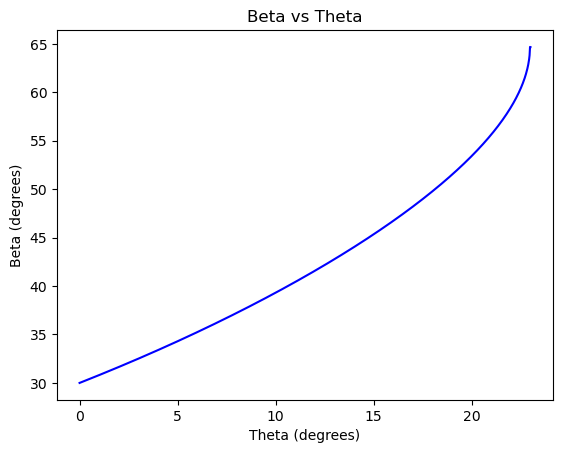

In [8]:
Theta_obj_vec = np.linspace(0,23.0,1001)

# Vectorize the function to handle arrays efficiently
find_beta_vec = np.vectorize(find_beta_for_theta)

# Find beta values for all Theta values in Theta_obj_vec
beta = find_beta_vec(Theta_obj_vec, M1, gamma)

beta = np.array(beta)
plt.figure()
plt.plot(Theta_obj_vec, beta, color='blue')
plt.title('Beta vs Theta')
plt.xlabel('Theta (degrees)')
plt.ylabel('Beta (degrees)')
plt.show()

In [9]:
Mn1 = calc_Mn1(M1, beta)
Mn2 = calc_Mn2(Mn1, gamma)
M2_full = calc_M2(Mn2, beta, Theta_obj_vec)
rho2rho1_full = calc_rho2rho1(Mn1, gamma)
p2p1_full = calc_p2p1(Mn1, gamma)
T2T1_full = calc_T2T1(Mn1, gamma)

<>:3: SyntaxWarning: invalid escape sequence '\T'
<>:6: SyntaxWarning: invalid escape sequence '\T'
<>:9: SyntaxWarning: invalid escape sequence '\T'
<>:12: SyntaxWarning: invalid escape sequence '\T'
<>:3: SyntaxWarning: invalid escape sequence '\T'
<>:6: SyntaxWarning: invalid escape sequence '\T'
<>:9: SyntaxWarning: invalid escape sequence '\T'
<>:12: SyntaxWarning: invalid escape sequence '\T'
/var/folders/v_/5q1gkdc53z34pdsfnpkx2t340000gn/T/ipykernel_17482/1173007576.py:3: SyntaxWarning: invalid escape sequence '\T'
  axs[0, 0].set_xlabel('$\Theta$ (degrees)')
/var/folders/v_/5q1gkdc53z34pdsfnpkx2t340000gn/T/ipykernel_17482/1173007576.py:6: SyntaxWarning: invalid escape sequence '\T'
  axs[0, 1].set_xlabel('$\Theta$ (degrees)')
/var/folders/v_/5q1gkdc53z34pdsfnpkx2t340000gn/T/ipykernel_17482/1173007576.py:9: SyntaxWarning: invalid escape sequence '\T'
  axs[1, 0].set_xlabel('$\Theta$ (degrees)')
/var/folders/v_/5q1gkdc53z34pdsfnpkx2t340000gn/T/ipykernel_17482/1173007576.py:12: Sy

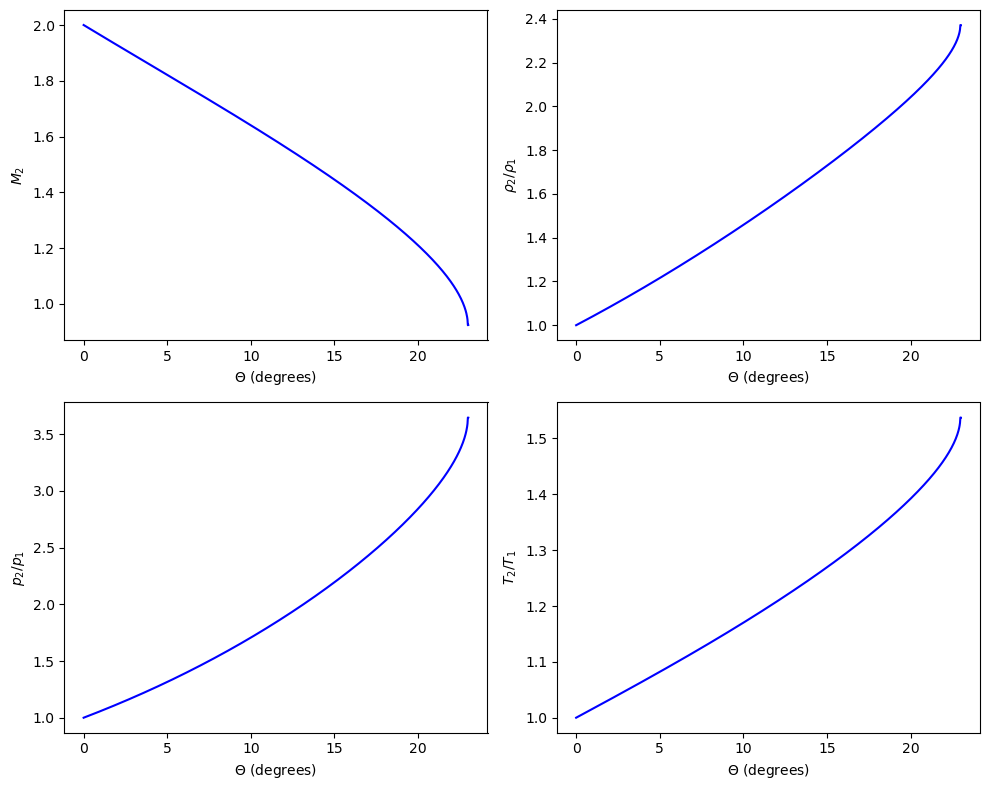

In [10]:
fig, axs = plt.subplots(2, 2, figsize=(10, 8))
axs[0, 0].plot(Theta_obj_vec, M2_full, color='blue')
axs[0, 0].set_xlabel('$\Theta$ (degrees)')
axs[0, 0].set_ylabel('$M_2$')
axs[0, 1].plot(Theta_obj_vec, rho2rho1_full, color='blue')
axs[0, 1].set_xlabel('$\Theta$ (degrees)')
axs[0, 1].set_ylabel('$\\rho_2/\\rho_1$')
axs[1, 0].plot(Theta_obj_vec, p2p1_full, color='blue')
axs[1, 0].set_xlabel('$\Theta$ (degrees)')
axs[1, 0].set_ylabel('$p_2/p_1$')
axs[1, 1].plot(Theta_obj_vec, T2T1_full, color='blue')
axs[1, 1].set_xlabel('$\Theta$ (degrees)')
axs[1, 1].set_ylabel('$T_2/T_1$')
plt.tight_layout()
plt.show()

In [11]:
# Theta_numerical = np.array([0, 5, 10, 15, 20, 23])
Theta_numerical = np.array([23])
beta_numerical = find_beta_vec(Theta_numerical, M1, gamma)
Mn1 = calc_Mn1(M1, beta_numerical)
Mn2 = calc_Mn2(Mn1, gamma)
M2_true = calc_M2(Mn2, beta_numerical, Theta_numerical)
rho2rho1_true = calc_rho2rho1(Mn1, gamma)
p2p1_true = calc_p2p1(Mn1, gamma)
T2T1_true = calc_T2T1(Mn1, gamma)

print("Results for Theta = 0, 5, 10, 15, 20, 23 degrees:")
for i, Theta_obj in enumerate(Theta_numerical):
    print(f"Theta = {Theta_obj} degrees:")
    print(f"beta = {beta_numerical[i]} degrees:")
    print(f"M2 = {M2_true[i]}")
    print(f"rho2/rho1 = {rho2rho1_true[i]}")
    print(f"p2/p1 = {p2p1_true[i]}")
    print(f"T2/T1 = {T2T1_true[i]}")
    print()

Results for Theta = 0, 5, 10, 15, 20, 23 degrees:
Theta = 23 degrees:
beta = 64.66860618207375 degrees:
M2 = 0.9247440231571138
rho2/rho1 = 2.3714505714220278
p2/p1 = 3.6457277732927267
T2/T1 = 1.537340823050166



/var/folders/v_/5q1gkdc53z34pdsfnpkx2t340000gn/T/ipykernel_17482/3972244343.py:4: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  return fsolve(f, initial_guess)[0]


In [12]:
# Load the line plot data
# angles = ['0.00000000000', '0.08715574274765817', '0.17364817766693033', '0.25881904510252074', '0.3420201433256687', '0.39073112848927377', '0.42261826174069944', '0.49999999999999994']
# csv_files_shock = [f'Figures/angle_value_{angle}_shock/lineplot.csv' for angle in angles]
angles = ['0.39073112848927377']
csv_files_shock = [f'Figures/angle_value_{angle}_shock/lineplot.csv' for angle in angles]
df_shock = [pd.read_csv(csv_file) for csv_file in csv_files_shock]

In [13]:
# Inflow
M1 = 2.
T1 = 300.
p1 = 101325.
rho1 = 1.174

<>:20: SyntaxWarning: invalid escape sequence '\T'
<>:20: SyntaxWarning: invalid escape sequence '\T'
/var/folders/v_/5q1gkdc53z34pdsfnpkx2t340000gn/T/ipykernel_17482/1867451068.py:20: SyntaxWarning: invalid escape sequence '\T'
  axs[row, col].set_xlabel('$\Theta [°]$')
/var/folders/v_/5q1gkdc53z34pdsfnpkx2t340000gn/T/ipykernel_17482/1867451068.py:33: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


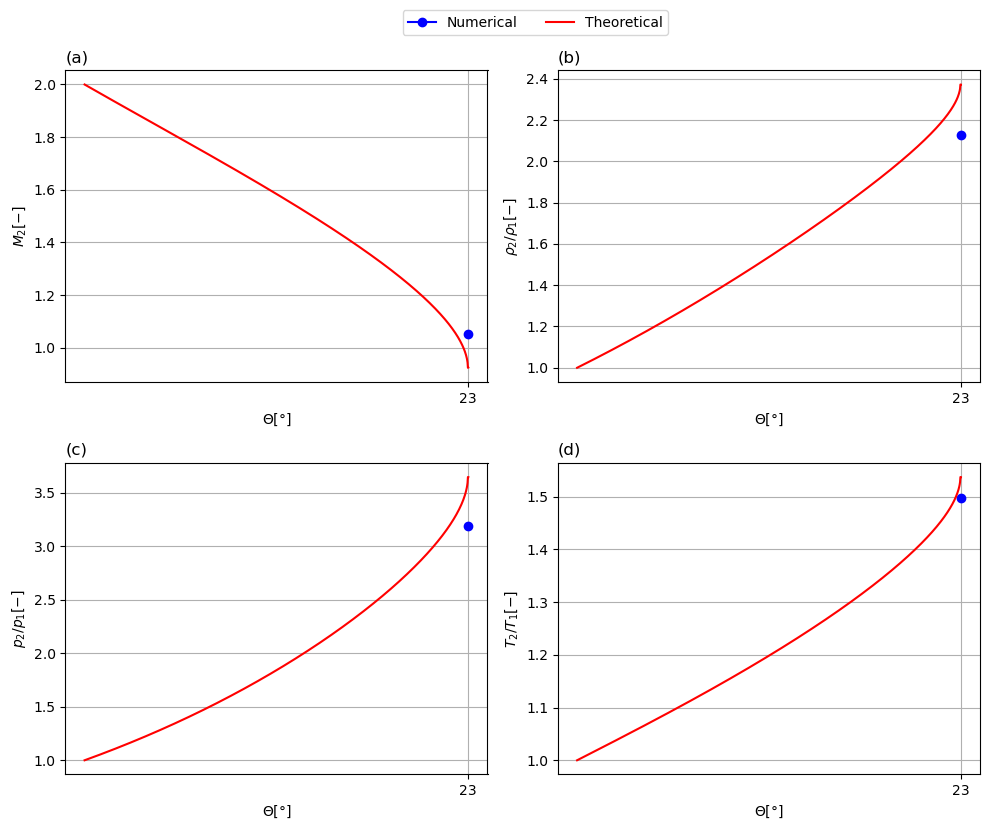

In [14]:
M2 = np.array([df_['Ma'].values[-1] for df_ in df_shock])
rho2 = np.array([df_['rho'].values[-1] for df_ in df_shock])
p2 = np.array([df_['p'].values[-1] for df_ in df_shock])
T2 = np.array([df_['T'].values[-1] for df_ in df_shock])

properties = ['M2', 'rho2/rho1', 'p2/p1', 'T2/T1']
values = [M2, rho2/rho1, p2/p1, T2/T1]
true_values = [M2_full, rho2rho1_full, p2p1_full, T2T1_full]
titles = ['(a)', '(b)', '(c)', '(d)']
y_labels = ['$M_2 [-]$', '$\\rho_2 / \\rho_1  [-]$', '$p_2 / p_1  [-]$', '$T_2 / T_1  [-]$']

# Plot each property in its respective subplot
fig, axs = plt.subplots(2, 2, figsize=(10, 8))
for i, (prop, val, true_val, title, y_label) in enumerate(zip(properties, values, true_values, titles, y_labels)):
    row, col = i // 2, i % 2
    Theta_num = Theta_numerical
    axs[row, col].plot(Theta_num, val, marker='o', color='blue')
    axs[row, col].plot(Theta_obj_vec, true_val, color='red')
    axs[row, col].set_title(title, loc='left')
    axs[row, col].set_xlabel('$\Theta [°]$')
    axs[row, col].set_ylabel(y_label)
axs[0,0].plot([], [], marker='o', color='blue', label='Numerical')
axs[0,0].plot([], [], color='red', label='Theoretical')
[ax.set_xticks(Theta_num) for ax in axs.flatten()]
# Create a single legend for all subplots
handles, labels = axs[0,0].get_legend_handles_labels()
fig.legend(handles, ['Numerical', 'Theoretical'], bbox_to_anchor=(0.68, 1.04), ncol=2)
# Adjust layout
fig.tight_layout()
[ax.grid() for ax in axs.flatten()]
# Save the figure
# plt.savefig('Figures/angle_value_cont.pdf', bbox_inches='tight')
fig.show()

In [15]:
# Convergence
nx = [50, 100, 200]
csv_files_convergence = [f'Figures/convergence/lineplot_{nx_}.csv' for nx_ in nx]
df_convergence = [pd.read_csv(csv_file) for csv_file in csv_files_convergence]

FileNotFoundError: [Errno 2] No such file or directory: 'Figures/convergence/lineplot_50.csv'

In [ ]:
Ma2, T2, T2T1, p2, p2p1, rho2, rho2rho1 = [], [], [], [], [], [], []
for i, df_ in enumerate(df_convergence):
    Ma2.append(df_['Ma'].values[-1])
    rho2.append(df_['rho'].values[-1])
    rho2rho1.append(df_['rho'].values[-1] / rho1)
    T2.append(df_['T'].values[-1])
    T2T1.append(df_['T'].values[-1] / T1)
    p2.append(df_['p'].values[-1])
    p2p1.append(df_['p'].values[-1] / p1)
Ma2 = np.array(Ma2)
rho2, rho2rho1 = np.array(rho2), np.array(rho2rho1)
T2, T2T1 = np.array(T2), np.array(T2T1)
p2, p2p1 = np.array(p2), np.array(p2p1)

Theta_ = 15
beta_ = find_beta_for_theta(Theta_, M1, gamma)
Mn1 = calc_Mn1(M1, beta_)
Mn2 = calc_Mn2(Mn1, gamma)
properties_analytical = [ # Ma2, p2/p1, T2/T1
    calc_M2(Mn2, beta_, Theta_),
    calc_rho2rho1(Mn1, gamma),
    calc_p2p1(Mn1, gamma),
    calc_T2T1(Mn1, gamma)
]

error_absolute = [
    np.abs(Ma2 - properties_analytical[0]),  
    np.abs(rho2rho1 - properties_analytical[1]),
    np.abs(p2p1 - properties_analytical[2]),
    np.abs(T2T1 - properties_analytical[3]),
]
error_relative = [
    np.abs(Ma2 - properties_analytical[0]) / properties_analytical[0],
    np.abs(rho2rho1 - properties_analytical[1]) / properties_analytical[1],
    np.abs(p2p1 - properties_analytical[2]) / properties_analytical[2],
    np.abs(T2T1 - properties_analytical[3]) / properties_analytical[3],
]

In [ ]:
print(f'Ma: \t Theoretical: {properties_analytical[0]} \t Numerical: {Ma2}')
print(f'rho2/rho1: \t Theoretical: {properties_analytical[1]} \t Numerical: {rho2rho1}')
print(f'p2/p1: \t Theoretical: {properties_analytical[2]} \t Numerical: {p2p1}')
print(f'T2/T1: \t Theoretical: {properties_analytical[3]} \t Numerical: {T2T1}')

Ma: 	 Theoretical: 1.445716365140514 	 Numerical: [1.4013 1.4168 1.4261]
rho2/rho1: 	 Theoretical: 1.7289223315067432 	 Numerical: [1.71942078 1.73415673 1.74003407]
p2/p1: 	 Theoretical: 2.1946531336076687 	 Numerical: [2.22195904 2.22718974 2.22580804]
T2/T1: 	 Theoretical: 1.2693763586794813 	 Numerical: [1.29223333 1.28426667 1.27913333]


/var/folders/v_/5q1gkdc53z34pdsfnpkx2t340000gn/T/ipykernel_16460/2043038156.py:8: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


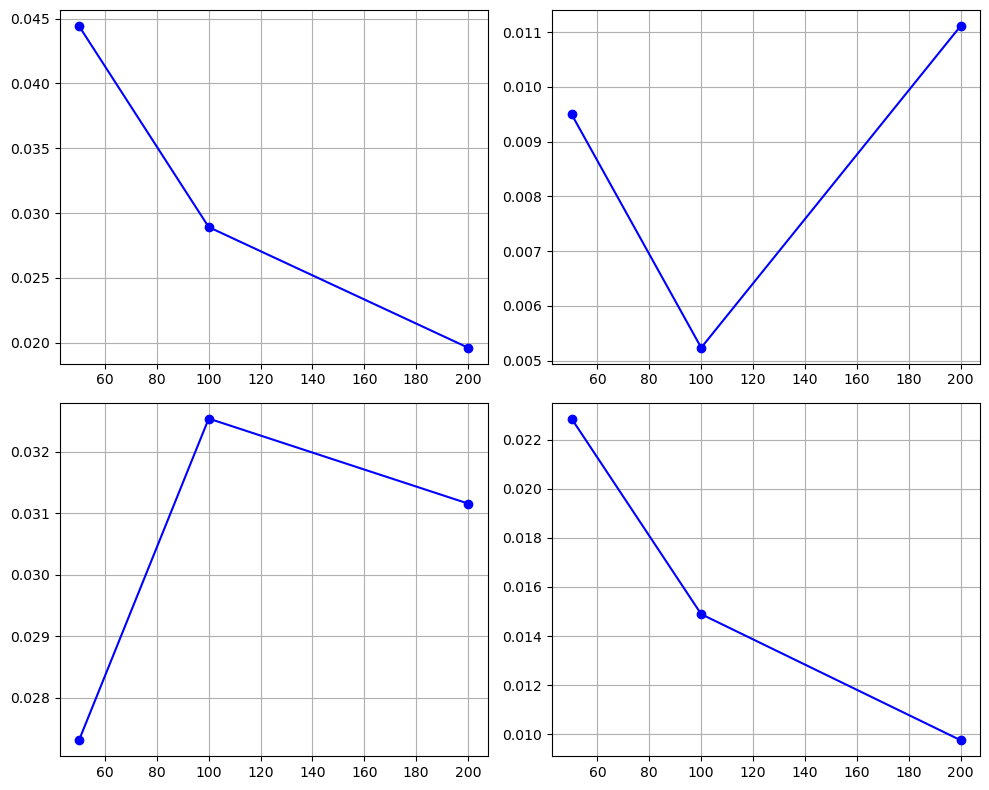

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(10, 8))
axs[0, 0].plot(nx, np.abs(Ma2 - properties_analytical[0]), marker='o', color='blue')
axs[0, 1].plot(nx, np.abs(rho2rho1 - properties_analytical[1]), marker='o', color='blue')
axs[1, 0].plot(nx, np.abs(p2p1 - properties_analytical[2]), marker='o', color='blue')
axs[1, 1].plot(nx, np.abs(T2T1 - properties_analytical[3]), marker='o', color='blue')
[ax.grid() for ax in axs.flatten()]
fig.tight_layout()
fig.show()